In [1]:
import pandas as pd
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt


In [2]:
train_df = pd.read_csv('final_data_season_3.csv.zip', compression='zip')
test_df = pd.read_csv('final_test_data_season_3.csv.zip', compression='zip')

In [3]:
train_df.head()

,Unnamed: 0,bid_id,region_id,city_id,ad_slot_visibility,ad_slot_format,creative_id,advertiser_id,сlick,part_of_day,weekday,weekend,os,browser,ad_slot_screen_share,is_mobile_device
0,0,9aa9b28f32adfc833634f28bb9703e83,216,219,Na,Fixed,7321,2259,False,2,3,2,windows,chrome,0.06,False
1,1,1ede4e457f5031ec1640dbe1259a4616,216,217,FirstView,Fixed,7321,2259,False,2,3,2,windows,ie,0.06,False
2,2,fca79371fc0f67ac6264f558bc664fd6,216,217,Na,Fixed,7323,2259,False,2,3,2,windows,chrome,0.07,False
3,3,7717c608f688ea3b087e292c91604ea5,183,184,Na,Fixed,10722,2821,False,2,3,2,windows,ie,0.07,False
4,4,35528d946791bc45b75ded2a2dbdabfe,3,3,FirstView,Fixed,10722,2821,False,2,3,2,windows,ie,0.07,False


In [4]:
train_df.columns

Index(['Unnamed: 0', 'bid_id', 'region_id', 'city_id', 'ad_slot_visibility',
       'ad_slot_format', 'creative_id', 'advertiser_id', 'сlick',
       'part_of_day', 'weekday', 'weekend', 'os', 'browser',
       'ad_slot_screen_share', 'is_mobile_device'],
      dtype='object')

In [5]:
train_df['click'] = train_df['сlick']
train_df = train_df.drop('сlick', axis=1)

In [6]:
pd.unique(train_df['click'])

array([False,  True])

In [7]:
test_df.columns

Index(['Unnamed: 0', 'bid_id', 'region_id', 'city_id', 'ad_slot_visibility',
       'ad_slot_format', 'creative_id', 'advertiser_id', 'user_profile_ids',
       'click', 'part_of_day', 'weekday', 'weekend', 'os', 'browser',
       'ad_slot_screen_share', 'is_mobile_device'],
      dtype='object')

In [8]:
pd.unique(train_df['click'])

array([False,  True])

In [9]:
train_df = train_df.drop('Unnamed: 0', axis=1)
test_df = test_df.drop('Unnamed: 0', axis=1)

In [10]:
test_df = test_df.drop('user_profile_ids', axis=1)

In [11]:
target_column = 'click'
feature_columns = train_df.columns.difference([target_column, 'bid_id'])
categorical_features = ['region_id', 'city_id', 'ad_slot_visibility', 
                        'ad_slot_format', 'creative_id', 'advertiser_id', 'part_of_day', 'weekday',
                        'os', 'browser', 'weekend']

In [12]:
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42, stratify=train_df[target_column])


In [13]:
train_pool = Pool(data=train_df[feature_columns],
                  label=train_df[target_column],
                  cat_features=categorical_features)

In [14]:
test_pool = Pool(data=test_df[feature_columns],
                 label=test_df[target_column],
                 cat_features=categorical_features)

In [16]:
val_pool = Pool(data=val_df[feature_columns],
                 label=val_df[target_column],
                 cat_features=categorical_features)

In [17]:
model = CatBoostClassifier(iterations=1000, 
                           learning_rate=0.1, 
                           depth=6, 
                           task_type='GPU',
                           loss_function='Logloss',
                           eval_metric='AUC',
                           verbose=100)

model.fit(train_pool, eval_set=val_pool, early_stopping_rounds=100, verbose=True)

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5334763	best: 0.5334763 (0)	total: 379ms	remaining: 6m 18s
1:	total: 1.14s	remaining: 9m 28s
2:	total: 1.91s	remaining: 10m 35s
3:	total: 2.68s	remaining: 11m 7s
4:	total: 3.46s	remaining: 11m 28s
5:	test: 0.7840180	best: 0.7847642 (4)	total: 4.22s	remaining: 11m 39s
6:	total: 4.99s	remaining: 11m 47s
7:	total: 5.75s	remaining: 11m 53s
8:	total: 6.52s	remaining: 11m 58s
9:	total: 7.3s	remaining: 12m 2s
10:	test: 0.8016977	best: 0.8016977 (10)	total: 8.06s	remaining: 12m 4s
11:	total: 8.87s	remaining: 12m 10s
12:	total: 9.62s	remaining: 12m 10s
13:	total: 10.4s	remaining: 12m 12s
14:	total: 11.3s	remaining: 12m 21s
15:	test: 0.8136853	best: 0.8136853 (15)	total: 12s	remaining: 12m 18s
16:	total: 12.9s	remaining: 12m 25s
17:	total: 13.8s	remaining: 12m 32s
18:	total: 14.4s	remaining: 12m 23s
19:	total: 15.1s	remaining: 12m 19s
20:	test: 0.8263284	best: 0.8263284 (20)	total: 15.7s	remaining: 12m 12s
21:	total: 16.4s	remaining: 12m 9s
22:	total: 17.1s	remaining: 12m 5s
23:	total

In [18]:
predictions = model.predict_proba(test_pool)[:, 1]

In [19]:
roc_auc = roc_auc_score(test_df[target_column], predictions)
print(f"ROC AUC Score: {roc_auc:.4f}")

ROC AUC Score: 0.6783


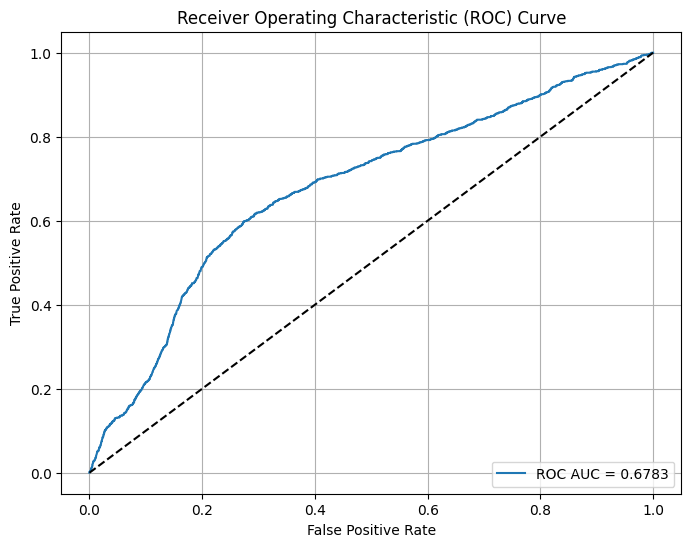

In [20]:
fpr, tpr, thresholds = roc_curve(test_df[target_column], predictions)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC AUC = {roc_auc:.4f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

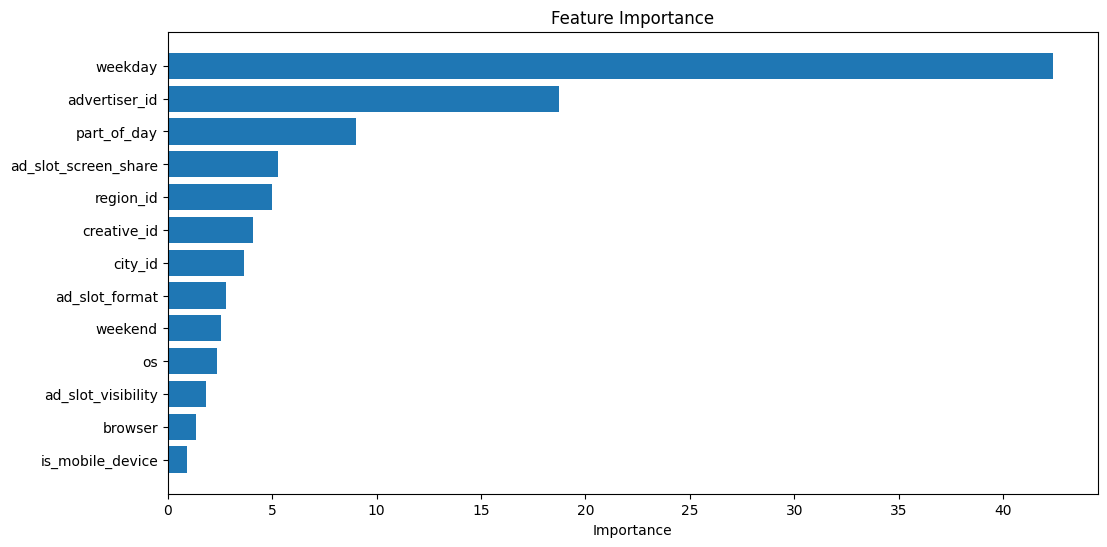

In [28]:
feature_importances = model.get_feature_importance(train_pool)
feature_importances_df = pd.DataFrame({'Feature': feature_columns, 'Importance': feature_importances})


feature_importances_df.sort_values(by='Importance', ascending=False, inplace=True)

plt.figure(figsize=(12, 6))
plt.barh(feature_importances_df['Feature'], feature_importances_df['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.gca().invert_yaxis()
plt.show()

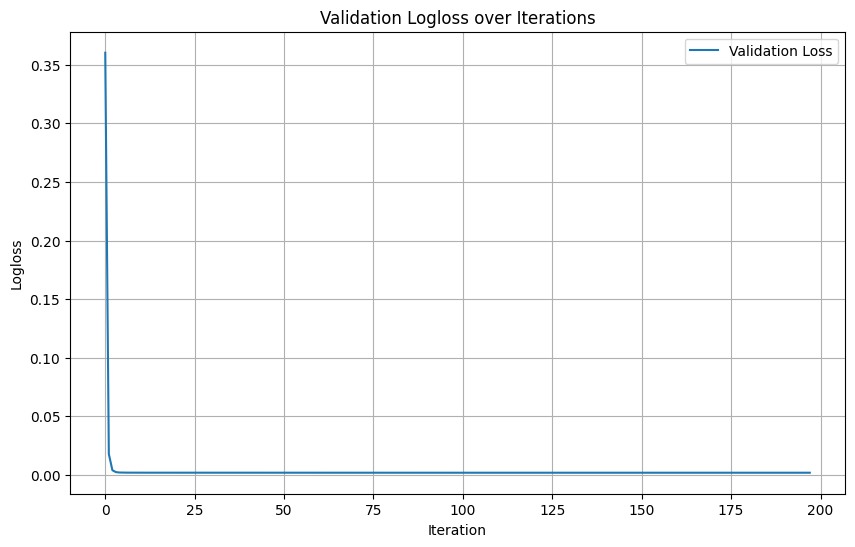

In [29]:
eval_results = model.get_evals_result()
validation_loss = eval_results['validation']['Logloss']

plt.figure(figsize=(10, 6))
plt.plot(range(0, len(validation_loss)), validation_loss, label='Validation Loss')
plt.xlabel('Iteration')
plt.ylabel('Logloss')
plt.title('Validation Logloss over Iterations')
plt.legend()
plt.grid()
plt.show()

In [30]:
model.save_model('catboost_model_season_3.cbm')

In [31]:
class_counts = train_df[target_column].value_counts()
class_counts

False    9163782
True        2153
Name: click, dtype: int64

In [32]:
class_0_count = class_counts.get(0, 1)
class_1_count = class_counts.get(1, 1)
class_0_count

9163782

0:	learn: 0.6878841	test: 0.6877690	best: 0.6877690 (0)	total: 498ms	remaining: 4m 8s
1:	learn: 0.6829241	test: 0.6826249	best: 0.6826249 (1)	total: 1.03s	remaining: 4m 16s
2:	learn: 0.6779115	test: 0.6775480	best: 0.6775480 (2)	total: 1.53s	remaining: 4m 14s
3:	learn: 0.6730228	test: 0.6725938	best: 0.6725938 (3)	total: 2.04s	remaining: 4m 12s
4:	learn: 0.6682554	test: 0.6677625	best: 0.6677625 (4)	total: 2.54s	remaining: 4m 11s
5:	learn: 0.6639236	test: 0.6634087	best: 0.6634087 (5)	total: 3.03s	remaining: 4m 9s
6:	learn: 0.6596813	test: 0.6591437	best: 0.6591437 (6)	total: 3.5s	remaining: 4m 6s
7:	learn: 0.6553480	test: 0.6546420	best: 0.6546420 (7)	total: 4.04s	remaining: 4m 8s
8:	learn: 0.6511181	test: 0.6502507	best: 0.6502507 (8)	total: 4.56s	remaining: 4m 8s
9:	learn: 0.6466007	test: 0.6456328	best: 0.6456328 (9)	total: 5.04s	remaining: 4m 6s
10:	learn: 0.6423932	test: 0.6413792	best: 0.6413792 (10)	total: 5.53s	remaining: 4m 6s
11:	learn: 0.6384444	test: 0.6372779	best: 0.6372

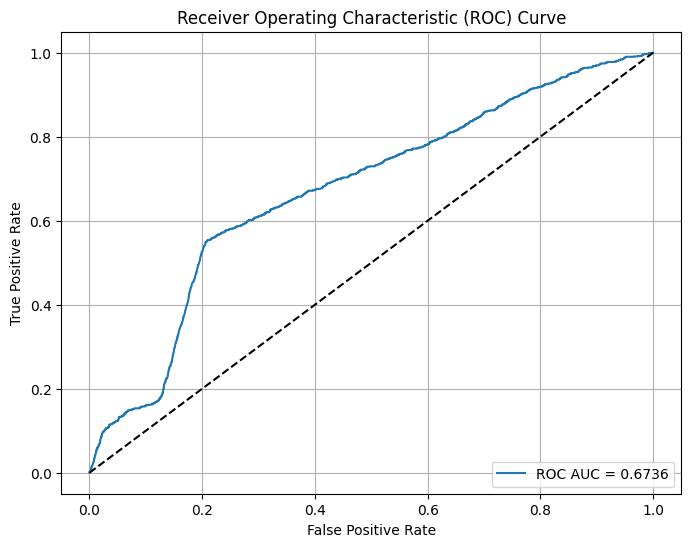

In [39]:
total_count = class_0_count + class_1_count
class_weights = [total_count / class_0_count, total_count / class_1_count]

model = CatBoostClassifier(iterations=500, 
                           learning_rate=0.01, 
                           depth=4, 
                           task_type='GPU',
                           loss_function='Logloss',
                           class_weights=class_weights,
                           eval_metric='Logloss',
                           verbose=100,
                           l2_leaf_reg=3)

model.fit(train_pool, eval_set=val_pool, early_stopping_rounds=100, verbose=True)

predictions = model.predict_proba(test_pool)[:, 1]

roc_auc = roc_auc_score(test_df[target_column], predictions)
print(f"ROC AUC Score: {roc_auc:.4f}")

fpr, tpr, thresholds = roc_curve(test_df[target_column], predictions)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC AUC = {roc_auc:.4f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

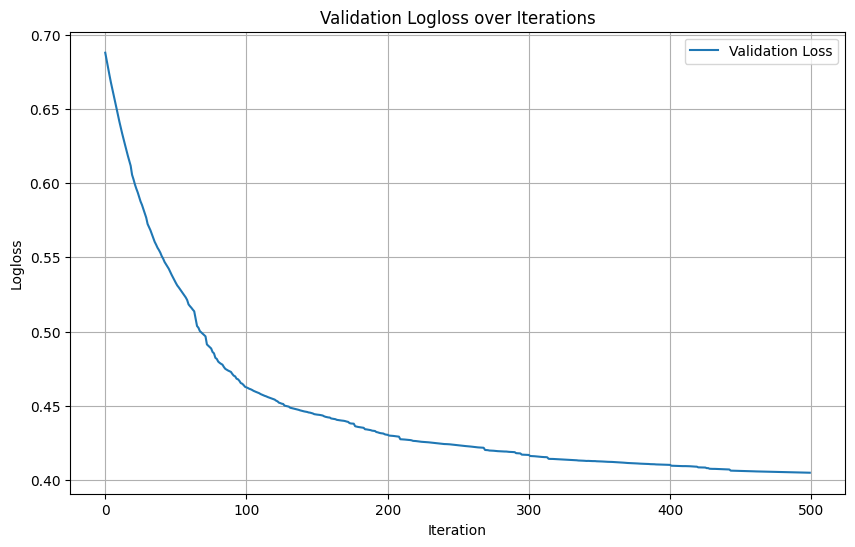

In [40]:
eval_results = model.get_evals_result()
validation_loss = eval_results['validation']['Logloss']

plt.figure(figsize=(10, 6))
plt.plot(range(0, len(validation_loss)), validation_loss, label='Validation Loss')
plt.xlabel('Iteration')
plt.ylabel('Logloss')
plt.title('Validation Logloss over Iterations')
plt.legend()
plt.grid()
plt.show()

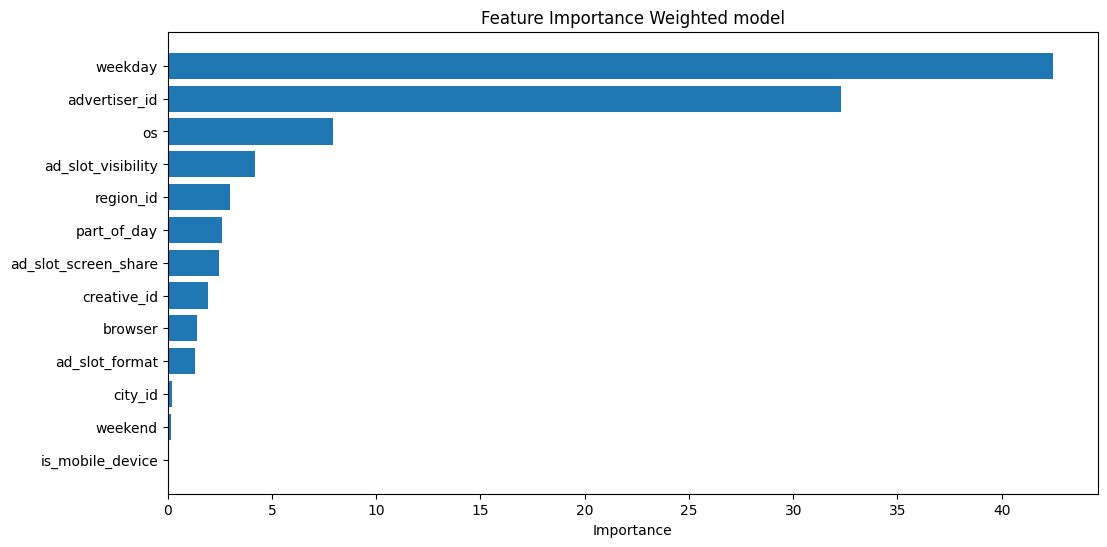

In [41]:
feature_importances = model.get_feature_importance(train_pool)
feature_importances_df = pd.DataFrame({'Feature': feature_columns, 'Importance': feature_importances})

feature_importances_df.sort_values(by='Importance', ascending=False, inplace=True)

plt.figure(figsize=(12, 6))
plt.barh(feature_importances_df['Feature'], feature_importances_df['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importance Weighted model')
plt.gca().invert_yaxis()
plt.show()

model.save_model('catboost_model_weighted_season_3.cbm')